In [1]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
from src.noise_addition import zero_signal, add_gaussian_noise
import copy
import random
import pickle

In [2]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [ ]:
def add_guassian_noise_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset

    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
        channels_to_corrupt = int(64 / 10 * severity_index)
        dataset[0][episode] = add_gaussian_noise(dataset[0][episode], 2 * severity_index, channels_to_corrupt, low, high)

    return dataset

In [ ]:
def add_zero_to_dataset(dataset, severity_index, low: int = 0, high: int = 308):
    if (severity_index == 0):
        return dataset
    
    length = len(dataset[0])
        # Add noise to 7.5%  * severityIndex of samples in the dataset. It can thus range from 5% to 50%
    episodes_to_corrupt = random.sample(range(0, length), int(0.1 * severity_index * length))
        # Add noise to the samples
    for episode in episodes_to_corrupt:
            # Can range from 5-50%
        channels_to_corrupt = int(64 / 20 * severity_index)
            # Zeroes the entire signal
        dataset[0][episode] = zero_signal(dataset[0][episode], channels_to_corrupt, low, high, 100)

    return dataset

In [3]:
# Plot the first 5 channels of the original signal, localized noise on 0-250ms, and localized noise on 250-500ms

train, val, test = create_dataset('./src/pickle_df', 1)

train_copy = copy.deepcopy(train)
guassian = add_guassian_noise_to_dataset(train_copy, 10)

train_copy = copy.deepcopy(train)
zeroed = add_zero_to_dataset(train_copy, 10)

duration = 308 / 512 * 1000
t = np.linspace(0, duration, 308)

figure, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(t, train[0][0][0], label='1')
axes[0].plot(t, train[0][0][1], label='2')
axes[0].plot(t, train[0][0][2], label="3")
axes[0].plot(t, train[0][0][3], label="4")
axes[0].plot(t, train[0][0][4], label="5")
axes[0].set_xlabel("Time (ms)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original")

axes[1].plot(t, guassian[0][0][0], label='1')
axes[1].plot(t, guassian[0][0][1], label='2')
axes[1].plot(t, guassian[0][0][2], label="3")
axes[1].plot(t, guassian[0][0][3], label="4")
axes[1].plot(t, guassian[0][0][4], label="5")
axes[1].set_xlabel("Time (ms)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Gaussian noise")

axes[2].plot(t, zeroed[0][0][0], label='1')
axes[2].plot(t, zeroed[0][0][1], label='2')
axes[2].plot(t, zeroed[0][0][2], label="3")
axes[2].plot(t, zeroed[0][0][3], label="4")
axes[2].plot(t, zeroed[0][0][4], label="5")
axes[2].set_xlabel("Time (ms)")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("Zeroed noise")

figure.tight_layout()
figure.suptitle("The effect of strong localized noise on the first 5 channels")
# Title and subtitle overlap, but its only for visualization

NameError: name 'add_guassian_noise_to_dataset' is not defined

In [ ]:
variances = [[] for _ in range(11)]
accuracies = [[] for _ in range(11)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', 1)

    for i in range(11):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_guassian_noise_to_dataset(train_copy, i)
        val_copy = add_guassian_noise_to_dataset(val_copy, i)
        test_copy = add_guassian_noise_to_dataset(test_copy, i)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/global_variances_gaussian.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/global_accuracies_gaussian.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

In [ ]:
variances = [[] for _ in range(11)]
accuracies = [[] for _ in range(11)]

for j in range(6):  
    # Load in the datasets with the current participant as test set
    train, val, test = create_dataset('./src/pickle_df', 1)

    for i in range(11):
        # Take deep copies
        train_copy = copy.deepcopy(train)
        val_copy = copy.deepcopy(val)
        test_copy = copy.deepcopy(test)
        
        # Add noise to the deep copies. If i is 0, noise is added to the lower end, when it is 1, it is added to the higher end
        # For this experiment, the intensity value is 5, resulting in a 'medium' level of noise
        train_copy = add_zero_to_dataset(train_copy, i)
        val_copy = add_zero_to_dataset(val_copy, i)
        test_copy = add_zero_to_dataset(test_copy, i)

        dm = DataModule(train=train_copy, val=val_copy, test=test_copy, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)
        # Train for 25 epochs for this example
        # Final one for results wil run for 50 most likely
        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        # Fit and test model
        trainer.fit(model, datamodule=dm)
        test_results = trainer.test(model, datamodule=dm)
        
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])
        accuracies[i].append(test_results[0]['test_acc'])

        # Save them to a pkl file
        with open('results_pickled/global_variances_zeroed.pkl', 'wb') as f:
            pickle.dump(variances, f)

        with open('results_pickled/global_accuracies_zeroed.pkl', 'wb') as f:
            pickle.dump(accuracies, f)
    
    # Just to visualize progress easier, the output is very messy
    print("\n\n\n\n\nFinished" + str(j) + "\n\n\n\n\n")

6


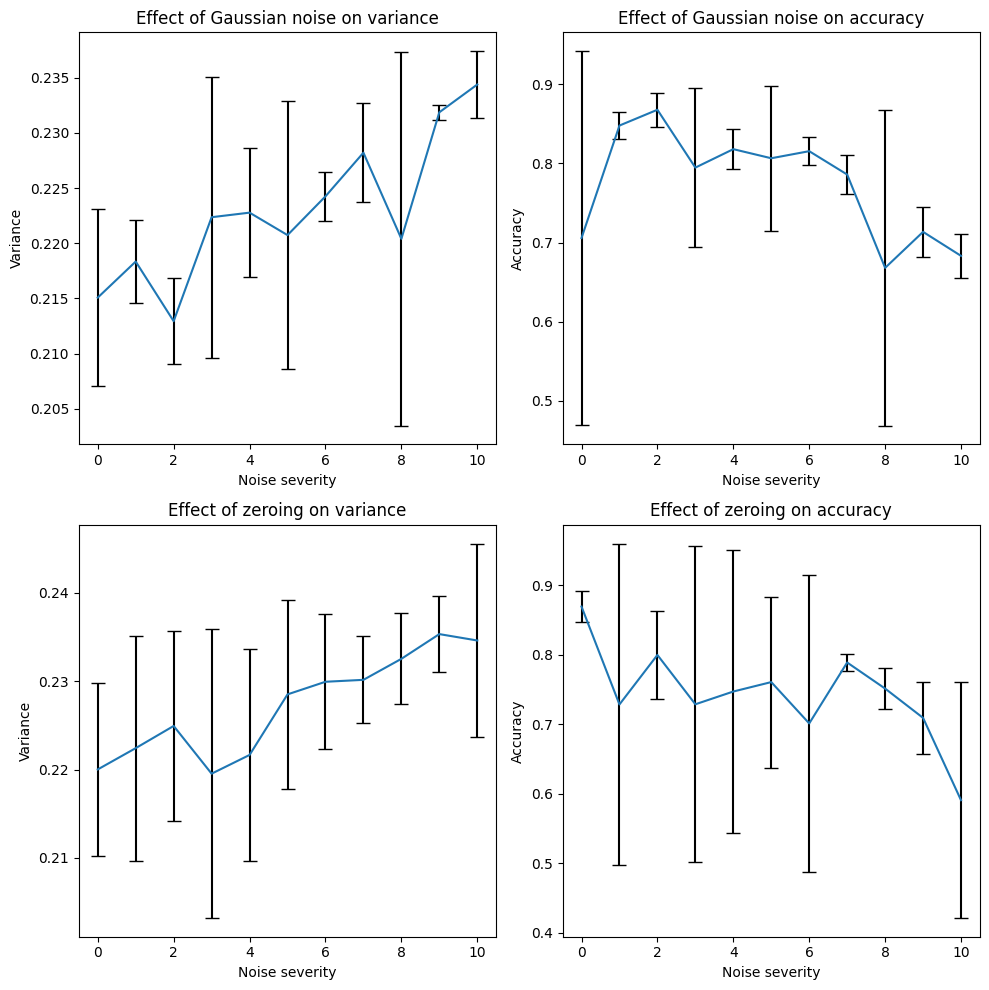

In [4]:
# Load in the .pkl files
with open('results_pickled/global_accuracies_gaussian.pkl', 'rb') as f:
    accuracies_gaussian = pickle.load(f)

print(len(accuracies_gaussian[0]))

with open('results_pickled/global_variances_gaussian.pkl', 'rb') as f:
    variances_gaussian = pickle.load(f)

with open('results_pickled/global_accuracies_zeroed.pkl', 'rb') as f:
    accuracies_zeroed = pickle.load(f)

with open('results_pickled/global_variances_zeroed.pkl', 'rb') as f:
    variances_zeroed = pickle.load(f)

standard_deviation_variances_gaussian = []
standard_deviation_accuracies_gaussian = []
standard_deviation_variances_zeroed = []
standard_deviation_accuracies_zeroed = []

for i in range(11):
    standard_deviation_variances_gaussian.append(np.asarray(variances_gaussian[i]).std())
    standard_deviation_accuracies_gaussian.append(np.asarray(accuracies_gaussian[i]).std())
    standard_deviation_variances_zeroed.append(np.asarray(variances_zeroed[i]).std())
    standard_deviation_accuracies_zeroed.append(np.asarray(accuracies_zeroed[i]).std())
    variances_gaussian[i] = np.asarray(variances_gaussian[i]).mean()
    accuracies_gaussian[i] = np.asarray(accuracies_gaussian[i]).mean()
    variances_zeroed[i] = np.asarray(variances_zeroed[i]).mean()
    accuracies_zeroed[i] = np.asarray(accuracies_zeroed[i]).mean()

t = np.asarray([0, 1, 2, 3, 4, 5, 6, 7 ,8, 9, 10])

# Plot the variances of the different levels of noise

figure, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].errorbar(t, variances_gaussian, yerr=standard_deviation_variances_gaussian, capsize=5, ecolor='k')
axes[0][0].plot()
axes[0][0].set_xlabel("Noise severity")
axes[0][0].set_ylabel("Variance")
axes[0][0].set_title("Effect of Gaussian noise on variance")
axes[0][1].errorbar(t, accuracies_gaussian, yerr=standard_deviation_accuracies_gaussian, capsize=5, ecolor='k')
axes[0][1].set_xlabel("Noise severity")
axes[0][1].set_ylabel("Accuracy")
axes[0][1].set_title("Effect of Gaussian noise on accuracy")

axes[1][0].errorbar(t, variances_zeroed, yerr=standard_deviation_variances_zeroed, capsize=5, ecolor='k')
axes[1][0].set_xlabel("Noise severity")
axes[1][0].set_ylabel("Variance")
axes[1][0].set_title("Effect of zeroing on variance")
axes[1][1].errorbar(t, accuracies_zeroed, yerr=standard_deviation_accuracies_zeroed, capsize=5, ecolor='k')
axes[1][1].set_xlabel("Noise severity")
axes[1][1].set_ylabel("Accuracy")
axes[1][1].set_title("Effect of zeroing on accuracy")

figure.tight_layout()
